In [95]:
"""
Disclaimer: this script has been co-developed with ChatGPT

We want to build a (n_models x 1032) array of Northern Hemisphere sea-ice extent (siextentn),
with columns = months from 2015-01 to 2100-12. The data is pre-processed thanks to Annelies Sticker.

Requirements:
  pip install xarray netCDF4 cftime numpy pandas

Notes:
- Handles non-standard calendars via xarray's cftime support.
- If a model is missing months (e.g., after 2099-12), the corresponding entries are NaN.
- Saves:
    - siextentn_s585_2015-2100.npy (float64 array)
    - siextentn_models.txt (model names, one per line, row-aligned with the array)
    - siextentn_time_months.csv (ISO YYYY-MM for each column)
"""

import re
import glob
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from scipy    import stats

import matplotlib
matplotlib.rcParams['font.family'] = "Arial Narrow"

In [80]:

# -----------------------------
# Config
# -----------------------------
DATA_DIR = Path("./processed_siextentn/MME/ssp585/")  # change if needed
PATTERN = "siextentn_SImon_*_ssp585_*_201501-*.nc"  # all files match this
VAR_NAME = "siextentn"

# Target monthly axis: 2015-01 ... 2100-12  (inclusive) => 86 years * 12 = 1032 months
time_axis = pd.date_range("2015-01-01", "2100-12-01", freq="MS")  # month starts
ncols = len(time_axis)  # 1032

# Helper: map (year, month) -> column index on the common axis
# Precompute a dict for fast lookup
ym_to_col = {(ts.year, ts.month): i for i, ts in enumerate(time_axis)}


In [81]:

# -----------------------------
# Discover files
# -----------------------------
files = sorted(DATA_DIR.glob(PATTERN))
if not files:
    raise FileNotFoundError(f"No files found with pattern: {DATA_DIR / PATTERN}")

# -----------------------------
# Extract a tidy model name from filename
# Examples:
#   siextentn_SImon_ACCESS-CM2_ssp585_r1i1p1f1_gn_201501-210012.nc  -> ACCESS-CM2
#   siextentn_SImon_MRI-ESM2-0_ssp585_r1i1p1f1_gm_201501-210012.nc -> MRI-ESM2-0
# -----------------------------
model_name_re = re.compile(r"siextentn_SImon_(.+?)_ssp585_")

def get_model_name(path: Path) -> str:
    m = model_name_re.search(path.name)
    return m.group(1) if m else path.stem

# -----------------------------
# Load each file, align to common axis, fill row
# -----------------------------
rows = []
model_names = []

for f in files:
    model = get_model_name(f)
    print(model)
    model_names.append(model)

    # Initialize with NaN for all months (in case of missing endpoints)
    row = np.full(ncols, np.nan, dtype="float64")

    # Open with cftime to handle non-standard calendars cleanly
    ds = xr.open_dataset(f, decode_times=True, use_cftime=True)

    if VAR_NAME not in ds:
        raise KeyError(f"{VAR_NAME} not found in {f.name}. Variables: {list(ds.data_vars)}")

    da = ds[VAR_NAME]

    # Ensure 'time' is present
    if ("time" not in da.dims) and ("time_bnds" not in da.dims):
        raise ValueError(f"No 'time' nor 'time_bnds' dimension in {f.name} for variable {VAR_NAME} for model {model}.")

    # Extract (year, month) from time that works with both datetime64 and cftime
    try:
        years = da["time"].dt.year.values
        months = da["time"].dt.month.values
    except KeyError:
        try:
            years = da["time_bnds"].dt.year.values
            months = da["time_bnds"].dt.month.values
        except KeyError:
            print("No time dimension found")

    # Pull the data as 1D array (assumes siextentn is monthly mean over NH; adjust if there's extra dims)
    # If there are extra dims, you might need to select/squeeze appropriately here.
    data_1d = da.squeeze().values
    if data_1d.ndim != 1 or data_1d.shape[0] != years.shape[0]:
        raise ValueError(
            f"Unexpected shape for {VAR_NAME} in {f.name}: {data_1d.shape}. "
            f"Expected 1D monthly time series matching 'time' length."
        )

    # Place each month's value into the common row using (year, month) -> column mapping
    for y, mth, val in zip(years, months, data_1d):
        idx = ym_to_col.get((int(y), int(mth)))
        if idx is not None:
            row[idx] = float(val)

    rows.append(row)

# Stack rows into final array
A = np.vstack(rows)  # shape = (n_models, 1032)


ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
CAMS-CSM1-0
CESM2-WACCM
CESM2
CNRM-CM6-1-HR
CNRM-CM6-1
CanESM5
EC-Earth3-Veg
EC-Earth3
GFDL-ESM4
HadGEM3-GC31-LL
HadGEM3-GC31-MM
IPSL-CM6A-LR
MIROC-ES2L
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorESM2-LM
NorESM2-MM
TaiESM1
UKESM1-0-LL


/opt/anaconda3/lib/python3.12/site-packages/xarray/conventions.py:431: SerializationWarning: variable 'siextentn' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [82]:

# -----------------------------
# Save outputs
# -----------------------------
np.save("siextentn_s585_2015-2100.npy", A)

with open("siextentn_models.txt", "w", encoding="utf-8") as fh:
    for name in model_names:
        fh.write(f"{name}\n")

# Save the column time axis as YYYY-MM for convenience
pd.Series(time_axis.strftime("%Y-%m"), name="month").to_csv("siextentn_time_months.csv", index=False)

print("Array shape:", A.shape)
print("Saved:")
print("  - siextentn_s585_2015-2100.npy")
print("  - siextentn_models.txt")
print("  - siextentn_time_months.csv")

print(A.shape)

Array shape: (25, 1032)
Saved:
  - siextentn_s585_2015-2100.npy
  - siextentn_models.txt
  - siextentn_time_months.csv
(25, 1032)


Text(0.5, 1.0, 'Raw data')

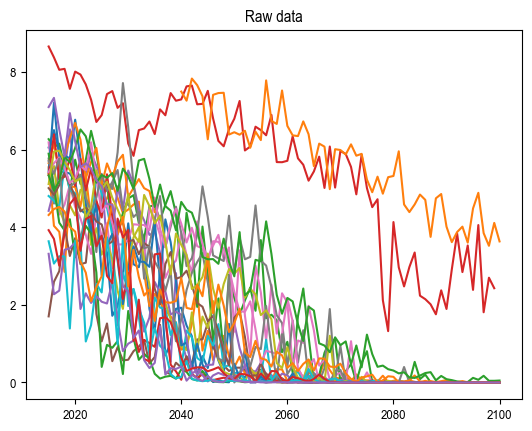

In [83]:
import matplotlib.pyplot as plt
years = np.arange(2015, 2101)
plt.plot(years, np.transpose(A[:,8::12]))
plt.title("Raw data")

(0.0, 5.0)

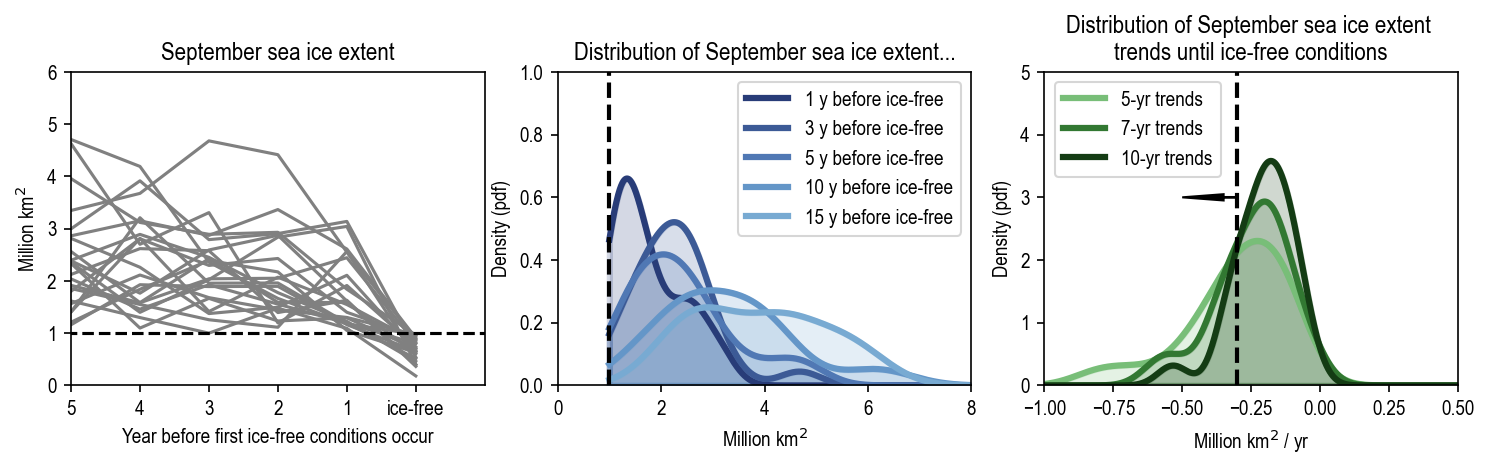

In [184]:
# Aligning everyhing on the first ice free date
fig, ax = plt.subplots(1, 3, figsize = (10, 3), dpi = 150)
B = np.full((A.shape[0], 20), np.nan) # B is a nmod by 20 matrix that stores the 20 values before ice free conditions occur
C = np.full((A.shape[0], 20), np.nan) # C is a nmod by 20 matrix that stores the 20 values of *trends* until ice free conditions occur

for i in range(A.shape[0]):
    # Find the first instance of ice-free
    series = A[i, 9::12]
    loc = np.where(series < 1.0)
    if len(loc[0]) >= 1:
        first = loc[0][0]
        newseries=series[first::-1][-1::-1] # Note that newseries is ordered with increasing time
        B[i, :]= newseries[-20:]
        newtimeaxis = np.arange(100, 100-len(newseries), -1)[-1::-1]
        ax[0].plot(newtimeaxis,newseries, color = [0.5, 0.5, 0.5])
        
        # Compute trends until ice-free conditions
        for j in range(B.shape[1] - 1):
            #print(np.arange(len(B[i, j:])))
            p = np.polyfit(np.arange(len(B[i, j:])), B[i, j:], 1)
            C[i, j] = p[0]
ax[0].set_xlabel("Year before first ice-free conditions occur")
ax[0].set_ylabel("Million km$^2$")
ax[0].set_title("September sea ice extent")

ax[0].set_xticks([100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90], ["ice-free", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])                   
ax[0].plot((0, 200), (1, 1), "k--")
ax[0].set_xlim(95, 101)
ax[0].set_ylim(0, 6)
plt.tight_layout()

pastel_blues = [
    (0.157, 0.235, 0.471),  # dark blue
    (0.235, 0.353, 0.588),
    (0.314, 0.471, 0.706),
    (0.392, 0.588, 0.784),
    (0.471, 0.667, 0.824),
    (0.549, 0.745, 0.863),
    (0.627, 0.804, 0.902),
    (0.706, 0.863, 0.922),
    (0.784, 0.902, 0.941),
    (0.863, 0.941, 0.961)   # very light pastel blue
]
ax[1].set_title("Distribution of September sea ice extent...")
for k, lag in enumerate([1 ,3, 5, 10, 15]):
    xpdf = np.linspace(1, 10, 1000)
    # Disregard nans
    thisData = B[:,-lag - 1]
    thisData=thisData[~np.isnan(thisData)]
    kernel = stats.gaussian_kde(thisData, bw_method = 0.5)
    pdf = kernel(xpdf).T
    ax[1].fill_between(xpdf, pdf , lw = 3, alpha = 0.2, color = pastel_blues[k])
    ax[1].plot(xpdf, pdf , lw = 3, color = pastel_blues[k], label = str(lag) + " y before ice-free")

ax[1].plot((1.0, 1.0), (0.0, 100), "k--", lw = 2)
ax[1].set_xlabel("Million km$^2$")
ax[1].set_ylabel("Density (pdf)")


ax[1].legend()    
ax[1].set_xlim(0.0, 8.0)
ax[1].set_ylim(0.0, 1.0)

# Trends
pastel_greens = [

  (0.471, 0.745, 0.471),
       (0.196, 0.471, 0.196), 
       (0.078, 0.235, 0.078),  # dark green
    
   
]

for k, lag in enumerate([5, 7, 10]):
    xpdf = np.linspace(-1, 1, 1000)
    # Disregard nans
    thisData = C[:,-lag - 1]
    thisData=thisData[~np.isnan(thisData)]
    kernel = stats.gaussian_kde(thisData, bw_method = 0.5)
    pdf = kernel(xpdf).T
    ax[2].fill_between(xpdf, pdf , lw = 3, alpha = 0.2, color = pastel_greens[k])
    ax[2].plot(xpdf, pdf , lw = 3, label = str(lag) + "-yr trends", color = pastel_greens[k])
ax[2].set_title("Distribution of September sea ice extent \ntrends until ice-free conditions")

ax[2].plot((-0.3, -0.3), (0.0, 100), "k--", lw = 2)
ax[2].set_xlabel("Million km$^2$ / yr")
ax[2].set_ylabel("Density (pdf)")
plt.arrow(-0.3, 3, -0.05, 0, width=0.01, color = "Black", head_width = 0.1)
ax[2].legend()    
ax[2].set_xlim(-1.0, 0.5)
ax[2].set_ylim(0.0, 5.0)